## 数据和包导入

In [1]:
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
plt.rcParams['figure.dpi'] = 80 
plt.rcParams.update({'font.size': 18})


roc_auc_values = []
precision_values = []
recall_values = []
f1_values = []
accuracy_values = []

with open('metrics/inner_metrics_list.pkl', 'rb') as f:
    inner_metrics_list = pickle.load(f)
with open('metrics/out_metrics_list.pkl', 'rb') as f:
    out_metrics_list = pickle.load(f)
with open('metrics/hold_metrics_list.pkl', 'rb') as f:
    hold_metrics_list = pickle.load(f)
with open('metrics/best_params_list.pkl', 'rb') as f:
    best_params_list = pickle.load(f)
with open('metrics/hold_params_list.pkl', 'rb') as f:
    hold_params_list = pickle.load(f)
with open('metrics/best_model_item.pkl', 'rb') as f:
    best_model_item = pickle.load(f)



model_name = ['SVM', 'AdaBoost', 'RandomForest', 'Stacking']

model_num = 4
epoch_num = 100 #Epoch调整了需要修改
outer_num = 5
inner_num = 3

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersi

### 模型信息

In [2]:
best_model = best_model_item['clf']
print(best_model_item['params'])
best_model

{'C': 97.59575423419442, 'n_estimators1': 34, 'learning_rate': 0.1397844793068377, 'n_estimators2': 149, 'max_depth': 54}


StackingClassifier(cv=3,
                   estimators=[('RF',
                                RandomForestClassifier(max_depth=54,
                                                       n_estimators=149,
                                                       random_state=0)),
                               ('SVM',
                                SVC(C=97.59575423419442, probability=True,
                                    random_state=0)),
                               ('Ada',
                                AdaBoostClassifier(learning_rate=0.1397844793068377,
                                                   n_estimators=34,
                                                   random_state=0))],
                   final_estimator=LogisticRegression(random_state=1),
                   n_jobs=-1)

In [3]:
y_true = best_model_item['eval'][0]
y_scores = best_model_item['eval'][1]
print([
    precision_score(y_true, (y_scores > 0.5).astype(int), zero_division = 1),
    classification_report(y_true, (y_scores > 0.5).astype(int), output_dict=True)['macro avg']['recall'],
    f1_score(y_true, (y_scores > 0.5).astype(int),zero_division = 1),
    balanced_accuracy_score(y_true, (y_scores > 0.5).astype(int)),
    roc_auc_score(y_true, y_scores)
])

[1.0, 0.9166666666666667, 0.9090909090909091, 0.9166666666666667, 0.8787878787878788]


### 四个模型外循环的ROC 曲线对比图

In [4]:
len(out_metrics_list) 

2000

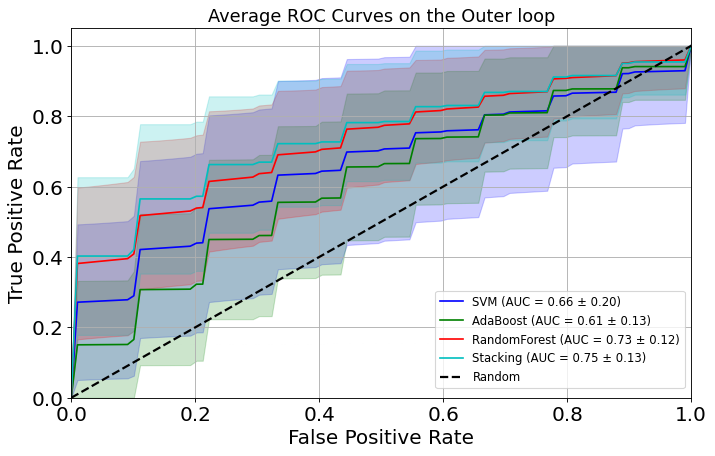

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import scipy.stats as stats


plt.figure(figsize=(10, 6))


model_info = [
    {"name": "SVM", "color": "b"},
    {"name": "AdaBoost", "color": "g"},
    {"name": "RandomForest", "color": "r"},
    {"name": "Stacking", "color": "c"},
]


roc_data = {model["name"]: {"fprs": [], "tprs": []} for model in model_info}


partition_size = epoch_num * outer_num
for model_idx, model in enumerate(model_info):
    start_idx = model_idx * partition_size
    end_idx = (model_idx + 1) * partition_size
    model_metrics = out_metrics_list[start_idx:end_idx]


    tprs = []
    mean_tpr = np.zeros(100)
    base_fpr = np.linspace(0, 1, 100)


    for i in range(epoch_num * outer_num):
        y_test_outer, y_pred_prob_outer = model_metrics[i]
        fpr, tpr, _ = roc_curve(y_test_outer, y_pred_prob_outer)
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
        mean_tpr += tpr

    mean_tpr /= epoch_num * outer_num
    mean_tpr[-1] = 1.0
    mean_auc = auc(base_fpr, mean_tpr)
    std_auc = np.std([auc(base_fpr, tpr) for tpr in tprs])
    std_tpr = np.std(tprs, axis=0)

    roc_data[model["name"]]["base_fpr"] = base_fpr
    roc_data[model["name"]]["mean_tpr"] = mean_tpr
    roc_data[model["name"]]["mean_auc"] = mean_auc
    roc_data[model["name"]]["std_auc"] = std_auc
    roc_data[model["name"]]["std_tpr"] = std_tpr


for model in model_info:
    base_fpr = roc_data[model["name"]]["base_fpr"]
    mean_tpr = roc_data[model["name"]]["mean_tpr"]
    mean_auc = roc_data[model["name"]]["mean_auc"]
    std_auc = roc_data[model["name"]]["std_auc"]
    std_tpr = roc_data[model["name"]]["std_tpr"]

    plt.plot(
        base_fpr,
        mean_tpr,
        color=model["color"],
        label=f'{model["name"]} (AUC = {mean_auc:.2f} ± {std_auc:.2f})',
    )
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color=model["color"], alpha=0.2)


plt.plot([0, 1], [0, 1], linestyle="--", color="k", lw=2, label="Random")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Average ROC Curves on the Outer loop", fontsize=16)
plt.legend(loc='lower right', bbox_to_anchor=(0.999, 0.01), fontsize='xx-small')
plt.grid()

plt.savefig("image/roc_curves.png", dpi=600, bbox_inches='tight')

plt.show()

### Holdout Set ROC 对比

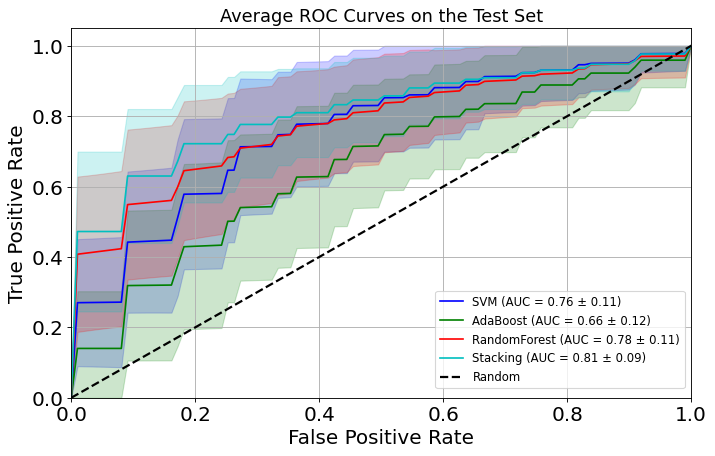

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
import scipy.stats as stats


plt.figure(figsize=(10, 6))

model_info = [
    {"name": "SVM", "color": "b"},
    {"name": "AdaBoost", "color": "g"},
    {"name": "RandomForest", "color": "r"},
    {"name": "Stacking", "color": "c"},
]

roc_data_holdout = {model["name"]: {"fprs": [], "tprs": []} for model in model_info}

partition_size = epoch_num
for model_idx, model in enumerate(model_info):
    start_idx = model_idx * partition_size
    end_idx = (model_idx + 1) * partition_size
    model_metrics = hold_metrics_list[start_idx:end_idx]

    tprs = []
    mean_tpr = np.zeros(100)
    base_fpr = np.linspace(0, 1, 100)

    for i in range(epoch_num):
        y_test_holdout, y_pred_prob_holdout = model_metrics[i]
        fpr, tpr, _ = roc_curve(y_test_holdout, y_pred_prob_holdout)
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
        mean_tpr += tpr

    mean_tpr /= epoch_num
    mean_tpr[-1] = 1.0
    mean_auc = auc(base_fpr, mean_tpr)
    std_auc = np.std([auc(base_fpr, tpr) for tpr in tprs])
    std_tpr = np.std(tprs, axis=0)

    roc_data_holdout[model["name"]]["base_fpr"] = base_fpr
    roc_data_holdout[model["name"]]["mean_tpr"] = mean_tpr
    roc_data_holdout[model["name"]]["mean_auc"] = mean_auc
    roc_data_holdout[model["name"]]["std_auc"] = std_auc
    roc_data_holdout[model["name"]]["std_tpr"] = std_tpr

for model in model_info:
    base_fpr = roc_data_holdout[model["name"]]["base_fpr"]
    mean_tpr = roc_data_holdout[model["name"]]["mean_tpr"]
    mean_auc = roc_data_holdout[model["name"]]["mean_auc"]
    std_auc = roc_data_holdout[model["name"]]["std_auc"]
    std_tpr = roc_data_holdout[model["name"]]["std_tpr"]

    plt.plot(
        base_fpr,
        mean_tpr,
        color=model["color"],
        label=f'{model["name"]} (AUC = {mean_auc:.2f} ± {std_auc:.2f})',
    )
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color=model["color"], alpha=0.2)

# Plot settings
plt.plot([0, 1], [0, 1], linestyle="--", color="k", lw=2, label="Random")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Average ROC Curves on the Test Set", fontsize=16)
plt.legend(loc='lower right', bbox_to_anchor=(0.999, 0.01), fontsize='xx-small')  # 修改了这行
plt.grid()

plt.savefig("image/hold_roc_curves.png", dpi=600, bbox_inches='tight')

plt.show()

In [7]:
from sklearn.metrics import confusion_matrix

for model_idx, model in enumerate(model_info):
    start_idx = model_idx * partition_size
    end_idx = (model_idx + 1) * partition_size
    model_metrics = hold_metrics_list[start_idx:end_idx]

    specificity_values = []

    for i in range(epoch_num):
        y_test_holdout, y_pred_prob_holdout = model_metrics[i]
        y_pred_holdout = (y_pred_prob_holdout > 0.5).astype(int)  
        tn, fp, fn, tp = confusion_matrix(y_test_holdout, y_pred_holdout).ravel()

        specificity = tn / (tn + fp)
        specificity_values.append(specificity)

    print(f"{model['name']}:")
    print(f"  Specificity: {np.mean(specificity_values):.3f} ± {np.std(specificity_values):.3f}")

SVM:
  Specificity: 0.768 ± 0.139
AdaBoost:
  Specificity: 0.632 ± 0.146
RandomForest:
  Specificity: 0.684 ± 0.145
Stacking:
  Specificity: 0.762 ± 0.138


### 每个模型循环epoch次,选出前epoch个效果最好的index就是该模型最好的,找到index推导参数

In [8]:
from sklearn.metrics import confusion_matrix


def calculate_sensitivity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    return sensitivity

def calculate_specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

metric_names = ['Sensitivity', 'Specificity', 'Balanced_Accuracy', 'AUC']

iteration_dataframes = []

for i, metrics in enumerate(hold_metrics_list):
    iteration_metrics = [i + 1]

    y_true = metrics[0]
    y_scores = metrics[1]
    iteration_metrics.extend([
        calculate_sensitivity(y_true, (y_scores > 0.5).astype(int)),
        calculate_specificity(y_true, (y_scores > 0.5).astype(int)),
        balanced_accuracy_score(y_true, (y_scores > 0.5).astype(int)),
        roc_auc_score(y_true, y_scores)
    ])
    tn, fp, fn, tp = confusion_matrix(y_true, (y_scores > 0.5).astype(int)).ravel()

    iteration_dataframe = pd.DataFrame([iteration_metrics], columns=['Iteration'] + metric_names)

    iteration_dataframes.append(iteration_dataframe)

df_metrics = pd.concat(iteration_dataframes, ignore_index=True)

df_metrics

,Iteration,Sensitivity,Specificity,Balanced_Accuracy,AUC
0,1,0.416667,1.000000,0.708333,0.795455
1,2,0.583333,0.909091,0.746212,0.871212
2,3,0.083333,0.727273,0.405303,0.469697
3,4,0.666667,0.909091,0.787879,0.810606
4,5,0.818182,0.833333,0.825758,0.848485
...,...,...,...,...,...
395,396,0.727273,0.750000,0.738636,0.765152
396,397,0.636364,0.583333,0.609848,0.765152
397,398,0.636364,0.750000,0.693182,0.704545
398,399,0.818182,0.750000,0.784091,0.825758


In [9]:
print(tn, fp, fn, tp)

8 4 2 9


In [10]:
best_auc_indices = []

for i in range(0, len(df_metrics), epoch_num):

    group_data = df_metrics.iloc[i:i + epoch_num]

    best_auc_index = group_data['AUC'].idxmax()

    best_auc_indices.append(best_auc_index)

print("Indices with the highest AUC for each group:")
print(best_auc_indices)

Indices with the highest AUC for each group:
[96, 168, 277, 368]


### Hold Out不同模型雷达对比

In [11]:
import pandas as pd
import numpy as np

df = pd.DataFrame(df_metrics)

average_values = df.groupby(df.index // (epoch_num)).mean()
average_values = average_values.iloc[:,1:].T
average_values.columns = ['SVM','Adaboost','RF','Stacking']

std_dev = df.groupby(df.index // (epoch_num)).std()
std_dev = std_dev.iloc[:,1:].T
std_dev.columns = ['SVM','Adaboost','RF','Stacking']

average_values = average_values.applymap('{:.2f}'.format) 
std_dev = std_dev.applymap('{:.2f}'.format) 

result = average_values + ' ± ' + std_dev

result = result.T

result

/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_3076/2010788840.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  average_values = average_values.applymap('{:.2f}'.format)
/var/folders/hj/sn71kqzs57x2snf3yz30cg1w0000gn/T/ipykernel_3076/2010788840.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  std_dev = std_dev.applymap('{:.2f}'.format)


,Sensitivity,Specificity,Balanced_Accuracy,AUC
SVM,0.59 ± 0.17,0.77 ± 0.14,0.68 ± 0.09,0.76 ± 0.11
Adaboost,0.63 ± 0.17,0.63 ± 0.15,0.63 ± 0.10,0.66 ± 0.12
RF,0.72 ± 0.14,0.68 ± 0.15,0.70 ± 0.11,0.78 ± 0.11
Stacking,0.75 ± 0.13,0.76 ± 0.14,0.75 ± 0.09,0.81 ± 0.10


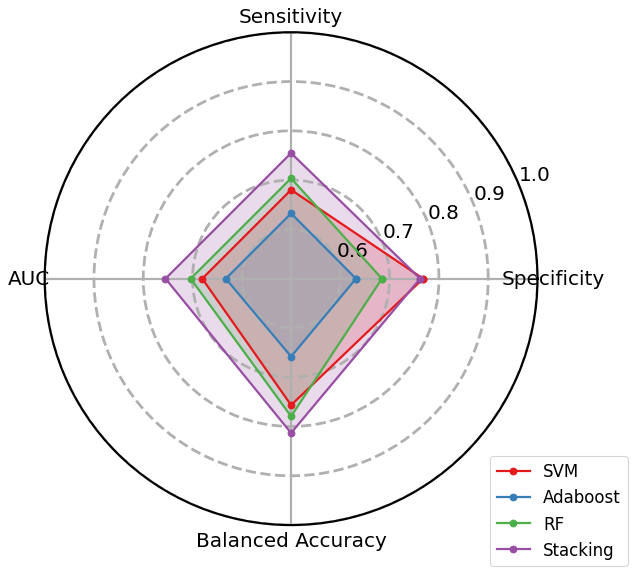

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, roc_auc_score

metric_names = ['Specificity', 'Sensitivity','AUC','Balanced Accuracy']

iteration_dataframes = []

for i, metrics in enumerate(hold_metrics_list):
    iteration_metrics = [i + 1]  
    
    y_true = metrics[0]
    y_pred = (metrics[1] > 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    iteration_metrics.extend([
        tn / (tn + fp),  
        classification_report(y_true, y_pred, output_dict=True)['macro avg']['recall'], 
        balanced_accuracy_score(y_true, y_pred),
        roc_auc_score(y_true, metrics[1])  
    ])
    
    iteration_dataframes.append(pd.DataFrame([iteration_metrics], columns=['Iteration'] + metric_names))


df_metrics = pd.concat(iteration_dataframes, ignore_index=True)

average_values = df_metrics.groupby(df_metrics.index // epoch_num).mean()
average_values = average_values.iloc[:,1:].T
average_values.columns = ['SVM','Adaboost','RF','Stacking']

labels = np.array(average_values.index.tolist())
data1 = average_values['SVM'].values
data2 = average_values['Adaboost'].values
data3 = average_values['RF'].values
data4 = average_values['Stacking'].values

data1 = np.concatenate((data1, [data1[0]]))
data2 = np.concatenate((data2, [data2[0]]))
data3 = np.concatenate((data3, [data3[0]]))
data4 = np.concatenate((data4, [data4[0]]))

angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)

ax.plot(angles, data1, 'o-', linewidth=2, label='SVM', color='#e41a1c')
ax.fill(angles, data1, color='#e41a1c', alpha=0.2)
ax.plot(angles, data2, 'o-', linewidth=2, label='Adaboost', color='#377eb8')
ax.fill(angles, data2, color='#377eb8', alpha=0.2)
ax.plot(angles, data3, 'o-', linewidth=2, label='RF', color='#4daf4a')
ax.fill(angles, data3, color='#4daf4a', alpha=0.2)
ax.plot(angles, data4, 'o-', linewidth=2, label='Stacking', color='#984ea3')
ax.fill(angles, data4, color='#984ea3', alpha=0.2)

ax.set_thetagrids(angles[:-1] * 180/np.pi, labels)
ax.set_rlim(0.5,1.0)

ax.yaxis.grid(True, linestyle='dashed',linewidth=2.5)

ax.xaxis.grid(True, linewidth=2)

ax.spines['polar'].set_linewidth(2)

plt.legend(loc='lower right', bbox_to_anchor=(1.2, -0.1), fontsize=15)

plt.savefig("image/compare_holdout.png", dpi=600, bbox_inches='tight')

plt.show()

In [13]:
model_names = [model["name"] for model in model_info]

### Holdout最优参数

In [14]:
import json
params_dict = dict(zip(model_names,[x for x in np.array(hold_params_list)[best_auc_indices]]))

print(json.dumps(params_dict, indent=4))

{
    "SVM": {
        "kernel": "poly",
        "C": 0.6272619266100633,
        "gamma": "scale",
        "class_weight": "balanced",
        "probability": true
    },
    "AdaBoost": {
        "n_estimators": 68,
        "learning_rate": 0.09166794557774093
    },
    "RandomForest": {
        "n_estimators": 266,
        "max_depth": 4
    },
    "Stacking": {
        "C": 62.6949420735323,
        "n_estimators1": 45,
        "learning_rate": 0.1590783358961756,
        "n_estimators2": 164,
        "max_depth": 23
    }
}


### Holdout Set 最优模型指标

In [15]:
best_holdout_metrics =  np.array(hold_metrics_list)[best_auc_indices]

,Model,Precision,Recall,F1 Score,Balanced_Accurary,AUC
0,SVM,1.0,0.863636,0.842105,0.863636,0.969697
1,AdaBoost,0.8,0.780303,0.761905,0.780303,0.901515
2,RandomForest,1.0,0.954545,0.952381,0.954545,1.000000
3,Stacking,1.0,0.863636,0.842105,0.863636,1.000000


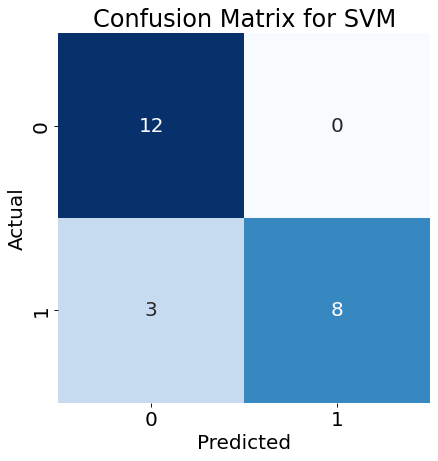

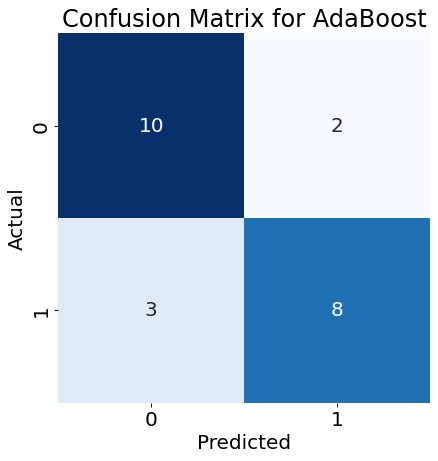

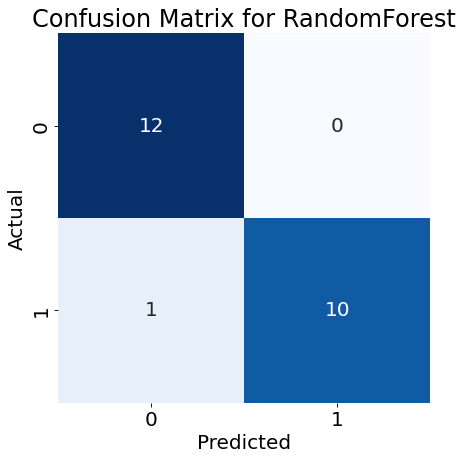

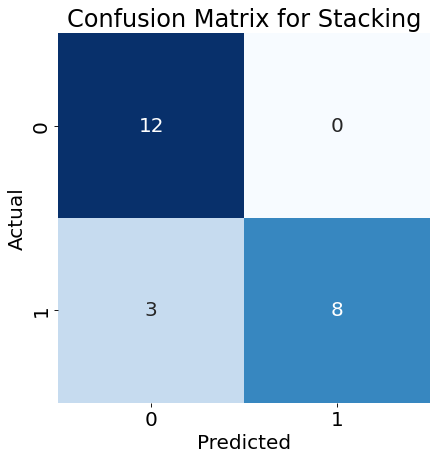

In [16]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix
)
import seaborn as sns


model_names = ['SVM', 'AdaBoost', 'RandomForest', 'Stacking']


precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []
auc_scores = []


confusion_matrices = []


for model_name in model_names:
    model_index = model_names.index(model_name)
    y_true = best_holdout_metrics[model_index][0]  
    y_pred_prob = best_holdout_metrics[model_index][1] 

    precision = precision_score(y_true, (y_pred_prob > 0.5).astype(int))
    recall = classification_report(y_true, (y_pred_prob > 0.5).astype(int), output_dict=True)['macro avg']['recall']
    f1 = f1_score(y_true, (y_pred_prob > 0.5).astype(int))
    accuracy = balanced_accuracy_score(y_true, (y_pred_prob > 0.5).astype(int))
    auc = roc_auc_score(y_true, y_pred_prob)

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)
    auc_scores.append(auc)


    cm = confusion_matrix(y_true, (y_pred_prob > 0.5).astype(int))
    confusion_matrices.append(cm)


metrics_df = pd.DataFrame({
    'Model': model_names,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores,
    'Balanced_Accurary': accuracy_scores,
    'AUC': auc_scores
})


display(metrics_df)

for i, model_name in enumerate(model_names):
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion_matrices[i], annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

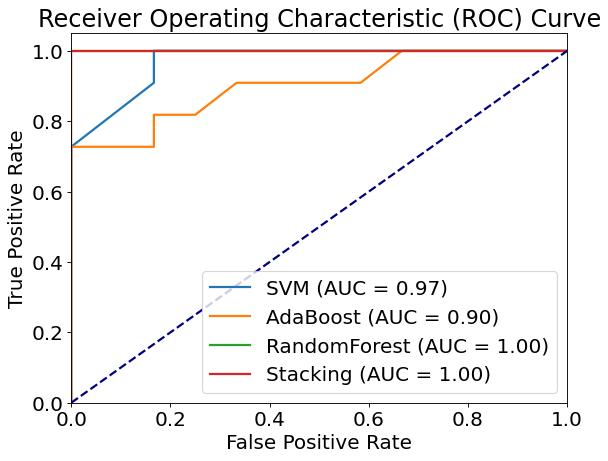

In [17]:
from sklearn.metrics import roc_curve, auc


roc_curves = []

for model_index, model_name in enumerate(model_names):
    y_true = best_holdout_metrics[model_index][0]
    y_pred_prob = best_holdout_metrics[model_index][1]

    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    roc_curves.append((fpr, tpr, roc_auc))

plt.figure(figsize=(8, 6))
for model_index, model_name in enumerate(model_names):
    fpr, tpr, roc_auc = roc_curves[model_index]
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### 输出Excel所有指标文件

In [18]:
from sklearn.metrics import recall_score, roc_auc_score, confusion_matrix
import numpy as np

def calculate_metrics(y_true, y_pred_prob, threshold=0.5):
    y_pred = (y_pred_prob >= threshold).astype(int)

    # Sensitivity aka recall
    sensitivity = recall_score(y_true, y_pred)

    # Specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)

    # Balanced Accuracy
    balanced_accuracy = (sensitivity + specificity) / 2

    # AUC
    auc_score = roc_auc_score(y_true, y_pred_prob)

    return sensitivity, specificity, balanced_accuracy, auc_score


inner_metrics_data = []
outer_metrics_data = []
hold_metrics_data = []

for model_idx, model_name in enumerate(model_names):
    for epoch in range(epoch_num):
        for outer in range(outer_num):
            for inner in range(inner_num):
                inner_data = inner_metrics_list[(model_idx * epoch_num * outer_num) + outer_num * epoch + outer]
                y_true, y_pred_prob = inner_data
                sensitivity, specificity, balanced_accuracy, auc_score = calculate_metrics(y_true, y_pred_prob)

                inner_metrics_data.append({
                    'Model': model_name,
                    'Epoch': epoch + 1,
                    'Outer': outer + 1,
                    'Inner': inner + 1,
                    'Sensitivity': sensitivity,
                    'Specificity': specificity,
                    'Balanced_Accuracy': balanced_accuracy,
                    'AUC': auc_score
                })

for model_idx, model_name in enumerate(model_names):
    for epoch in range(epoch_num):
        for outer in range(outer_num):
            outer_data = out_metrics_list[(model_idx * epoch_num * outer_num) + outer_num * epoch + outer]
            y_true, y_pred_prob = outer_data
            sensitivity, specificity, balanced_accuracy, auc_score = calculate_metrics(y_true, y_pred_prob)

            outer_metrics_data.append({
                'Model': model_name,
                'Epoch': epoch + 1,
                'Outer': outer + 1,
                'Sensitivity': sensitivity,
                'Specificity': specificity,
                'Balanced_Accuracy': balanced_accuracy,
                'AUC': auc_score
            })

for model_idx, model_name in enumerate(model_names):
    for epoch in range(epoch_num):
            hold_data = hold_metrics_list[model_idx * epoch_num + epoch]
            y_true, y_pred_prob = hold_data
            sensitivity, specificity, balanced_accuracy, auc_score = calculate_metrics(y_true, y_pred_prob)
            hold_metrics_data.append({
                'Model': model_name,
                'Epoch': epoch + 1,
                'Sensitivity': sensitivity,
                'Specificity': specificity,
                'Balanced_Accuracy': balanced_accuracy,
                'AUC': auc_score
            })

inner_metrics_df = pd.DataFrame(inner_metrics_data)
outer_metrics_df = pd.DataFrame(outer_metrics_data)
hold_metrics_df = pd.DataFrame(hold_metrics_data)

with pd.ExcelWriter('metrics/model_metrics.xlsx') as writer:
    inner_metrics_df.to_excel(writer, sheet_name='InnerMetrics', index=False)
    outer_metrics_df.to_excel(writer, sheet_name='OuterMetrics', index=False)
    hold_metrics_df.to_excel(writer, sheet_name='HolderMetrics', index=False)

print("Excel file 'model_metrics.xlsx' saved successfully.")

Excel file 'model_metrics.xlsx' saved successfully.


In [19]:
from tabulate import tabulate
import pandas as pd
import numpy as np

model_names = inner_metrics_df['Model'].unique()

results_df = pd.DataFrame()


def calculate_metrics_average_std(df, model_name):
    metrics = df[df['Model'] == model_name]

    numeric_metrics = metrics.select_dtypes(include=[np.number])
    averages = numeric_metrics.mean()
    std_devs = numeric_metrics.std()
    results = {'Average': averages, 'Standard Deviation': std_devs}
    return results

for model_name in model_names:
    inner_metrics = calculate_metrics_average_std(inner_metrics_df, model_name)
    outer_metrics = calculate_metrics_average_std(outer_metrics_df, model_name)

    model_results = {}

    for metric in ['Sensitivity', 'Specificity', 'Balanced_Accuracy', 'AUC']:
        inner_avg = inner_metrics['Average'][metric]
        inner_std = inner_metrics['Standard Deviation'][metric]
        outer_avg = outer_metrics['Average'][metric]
        outer_std = outer_metrics['Standard Deviation'][metric]

        model_results[metric] = f"{outer_avg:.2f} ± {outer_std:.2f}({inner_avg:.2f} ± {inner_std:.2f})"

    results_df[model_name] = pd.Series(model_results)


results_df = results_df.transpose()


print(tabulate(results_df, tablefmt="pipe", headers="keys"))

|              | Sensitivity              | Specificity              | Balanced_Accuracy        | AUC                      |
|:-------------|:-------------------------|:-------------------------|:-------------------------|:-------------------------|
| SVM          | 0.61 ± 0.24(0.51 ± 0.35) | 0.62 ± 0.26(0.51 ± 0.36) | 0.61 ± 0.15(0.51 ± 0.12) | 0.66 ± 0.20(0.50 ± 0.20) |
| AdaBoost     | 0.61 ± 0.17(0.55 ± 0.32) | 0.58 ± 0.17(0.48 ± 0.37) | 0.60 ± 0.11(0.51 ± 0.11) | 0.61 ± 0.13(0.51 ± 0.20) |
| RandomForest | 0.70 ± 0.16(0.52 ± 0.33) | 0.63 ± 0.17(0.51 ± 0.37) | 0.66 ± 0.11(0.52 ± 0.11) | 0.73 ± 0.12(0.53 ± 0.21) |
| Stacking     | 0.69 ± 0.18(0.60 ± 0.17) | 0.70 ± 0.19(0.54 ± 0.17) | 0.69 ± 0.11(0.57 ± 0.10) | 0.75 ± 0.13(0.59 ± 0.12) |


In [ ]:
print("全部完成！！")